# Copyright Netherlands eScience Center <br>
** Function     : MCA analysis of SIC forecast with ConvLSTM** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.05.21 ** <br>
** Last Update  : 2020.03.04 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib **<br>
Description     : This notebook serves to predict the Arctic sea ice using deep learning. We also include many climate index (to represent the forcing from atmosphere). The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Here we predict sea ice concentration with one extra relevant field from either ocean or atmosphere to test the predictor.** <br>

Return Values   : Time series and figures <br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DeepClim'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DeepClim")
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
import deepclim.deepArray
#import deepclim.deepArrayStep
#import deepclim.function

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
#datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
datapath_ERAI = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ERA-Interim'
#datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4 = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_ORAS4_mask = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_PIOMASS = 'H:\\Creator_Zone\\Core_Database_AMET_OMET_reanalysis\\PIOMASS'
#datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
datapath_clim_index = 'F:\\PhD_essential\\Core_Database_AMET_OMET_reanalysis\\Climate_index'
#output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps'
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\Maps'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    # weekly variables on ERAI grid
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_slp = Dataset(os.path.join(datapath_ERAI,
                                      'slp_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_t2m = Dataset(os.path.join(datapath_ERAI,
                                      't2m_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_z500 = Dataset(os.path.join(datapath_ERAI,
                                       'z500_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_z850 = Dataset(os.path.join(datapath_ERAI,
                                       'z850_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_uv10m = Dataset(os.path.join(datapath_ERAI,
                                       'uv10m_weekly_erai_1979_2017.nc'))
    dataset_ERAI_fields_rad = Dataset(os.path.join(datapath_ERAI,
                                        'rad_flux_weekly_erai_1979_2017.nc'))
    #dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
    #                             'siv_monthly_PIOMASS_1979_2017.nc'))
    # OHC interpolated on ERA-Interim grid
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                'ohc_monthly_oras2erai_1978_2017.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                            'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim) - benckmark
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    # T2M (ERA-Interim)
    T2M_ERAI = dataset_ERAI_fields_t2m.variables['t2m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_t2m = dataset_ERAI_fields_t2m.variables['year'][:-1]
    week_ERAI_t2m = dataset_ERAI_fields_t2m.variables['week'][:]
    latitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['latitude'][:]
    longitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['longitude'][:]
    # SLP (ERA-Interim)
    SLP_ERAI = dataset_ERAI_fields_slp.variables['slp'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_slp = dataset_ERAI_fields_slp.variables['year'][:-1]
    week_ERAI_slp = dataset_ERAI_fields_slp.variables['week'][:]
    latitude_ERAI_slp = dataset_ERAI_fields_slp.variables['latitude'][:]
    longitude_ERAI_slp = dataset_ERAI_fields_slp.variables['longitude'][:]
    # Z500 (ERA-Interim)
    Z500_ERAI = dataset_ERAI_fields_z500.variables['z'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_z500 = dataset_ERAI_fields_z500.variables['year'][:-1]
    week_ERAI_z500 = dataset_ERAI_fields_z500.variables['week'][:]
    latitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['latitude'][:]
    longitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['longitude'][:]
    # Z850 (ERA-Interim)
    Z850_ERAI = dataset_ERAI_fields_z850.variables['z'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_z850 = dataset_ERAI_fields_z850.variables['year'][:-1]
    week_ERAI_z850 = dataset_ERAI_fields_z850.variables['week'][:]
    latitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['latitude'][:]
    longitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['longitude'][:]
    # UV10M (ERA-Interim)
    U10M_ERAI = dataset_ERAI_fields_uv10m.variables['u10m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    V10M_ERAI = dataset_ERAI_fields_uv10m.variables['v10m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['year'][:-1]
    week_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['week'][:]
    latitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['latitude'][:]
    longitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['longitude'][:]
    # SFlux (ERA-Interim)
    SFlux_ERAI = dataset_ERAI_fields_rad.variables['SFlux'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI_SFlux = dataset_ERAI_fields_rad.variables['year'][:-1]
    week_ERAI_SFlux = dataset_ERAI_fields_rad.variables['week'][:]
    latitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['latitude'][:]
    longitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['longitude'][:]
    #SIV (PIOMASS)
    #SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    #year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / from 90 N upto 40 N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:-1,:,:67,:]/1000 # unit Peta Joule
    latitude_ORAS4 = dataset_ORAS4_OHC.variables['latitude'][:]
    longitude_ORAS4 = dataset_ORAS4_OHC.variables['longitude'][:]
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
    NAO = dataset_index.variables['NAO'][348:-1]
    NINO = dataset_index.variables['NINO'][348:-1]
    AMO = dataset_index.variables['AMO'][348:-1]
    PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [9]:
    # first check of grid
    print(latitude_ERAI)
    print(longitude_ERAI)
    print(latitude_ERAI_t2m)
    print(longitude_ERAI_t2m)
    print(longitude_ORAS4)

[89.5  88.75 88.   87.25 86.5  85.75 85.   84.25 83.5  82.75 82.   81.25
 80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25
 62.5  61.75 61.   60.25 59.5  58.75 58.   57.25 56.5  55.75 55.   54.25
 53.5  52.75 52.   51.25 50.5  49.75 49.   48.25 47.5  46.75 46.   45.25
 44.5  43.75 43.   42.25 41.5  40.75 40.  ]
[-180.   -179.25 -178.5  -177.75 -177.   -176.25 -175.5  -174.75 -174.
 -173.25 -172.5  -171.75 -171.   -170.25 -169.5  -168.75 -168.   -167.25
 -166.5  -165.75 -165.   -164.25 -163.5  -162.75 -162.   -161.25 -160.5
 -159.75 -159.   -158.25 -157.5  -156.75 -156.   -155.25 -154.5  -153.75
 -153.   -152.25 -151.5  -150.75 -150.   -149.25 -148.5  -147.75 -147.
 -146.25 -145.5  -144.75 -144.   -143.25 -142.5  -141.75 -141.   -140.25
 -139.5  -138.75 -138.   -137.25 -136.5  -135.75 -135.   -134.25 -133.5
 -132.75 -132.   -131.25 -130.5  -129.75 -129.   -128.25 -127.5  -126.75
 -126.   -125

In [8]:
    #################################################################################
    ###########                 global land-sea mask                      ###########
    #################################################################################
    sea_ice_mask_global = np.ones((len(latitude_ERAI),len(longitude_ERAI)),dtype=float)
    sea_ice_mask_global[SIC_ERAI[0,0,:,:]==-1] = 0
    #################################################################################
    ###########                regionalization sea mask                   ###########
    #################################################################################
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [5]:
    #################################################################################
    ########                  temporal interpolation matrix                  ########
    #################################################################################
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= deepclim.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [6]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    SFlux_ERAI_area = np.zeros(SFlux_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
        SFlux_ERAI_area[:,:,i,:] = SFlux_ERAI[:,:,i,:]* dx[i] * dy / 1E+12 # unit TeraWatt
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = deepclim.preprocess.operator.unfold(SIC_ERAI_area)
    T2M_ERAI_series = deepclim.preprocess.operator.unfold(T2M_ERAI)
    SLP_ERAI_series = deepclim.preprocess.operator.unfold(SLP_ERAI)
    Z500_ERAI_series = deepclim.preprocess.operator.unfold(Z500_ERAI)
    Z850_ERAI_series = deepclim.preprocess.operator.unfold(Z850_ERAI)
    U10M_ERAI_series = deepclim.preprocess.operator.unfold(U10M_ERAI)
    V10M_ERAI_series = deepclim.preprocess.operator.unfold(V10M_ERAI)
    SFlux_ERAI_area_series = deepclim.preprocess.operator.unfold(SFlux_ERAI_area)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [9]:
    print ('******************  choose the fields from target region  *******************')
    # select land-sea mask
    sea_ice_mask_barents = sea_ice_mask_global[12:36,264:320]
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,12:36,264:320]
    t2m_exp = T2M_ERAI_series[:,12:36,264:320]
    slp_exp = SLP_ERAI_series[:,12:36,264:320]
    z500_exp = Z500_ERAI_series[:,12:36,264:320]
    z850_exp = Z850_ERAI_series[:,12:36,264:320]
    u10m_exp = U10M_ERAI_series[:,12:36,264:320]
    v10m_exp = V10M_ERAI_series[:,12:36,264:320]
    sflux_exp = SFlux_ERAI_area_series[:,12:36,264:320]
    ohc_exp = OHC_300_ORAS4_weekly_series[:,12:36,264:320]
    print(sic_exp.shape)
    print(t2m_exp.shape)
    print(slp_exp.shape)
    print(z500_exp.shape)
    print(u10m_exp.shape)
    print(v10m_exp.shape)
    print(sflux_exp.shape)
    print(ohc_exp.shape)
    print(latitude_ERAI[12:36])
    print(longitude_ERAI[264:320])
    print(latitude_ORAS4[12:36])
    print(longitude_ORAS4[264:320])
    #print(latitude_ERAI[26:40])
    #print(longitude_ERAI[180:216])

******************  choose the fields from target region  *******************
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
(1824, 24, 56)
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.25 48.   48.75 49.5  50.25 51.   51.75 52.5  53.25
 54.   54.75 55.5  56.25 57.   57.75 58.5  59.25]
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  3

In [10]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = deepclim.preprocess.operator.normalize(sic_exp)
    t2m_exp_norm = deepclim.preprocess.operator.normalize(t2m_exp)
    slp_exp_norm = deepclim.preprocess.operator.normalize(slp_exp)
    z500_exp_norm = deepclim.preprocess.operator.normalize(z500_exp)
    z850_exp_norm = deepclim.preprocess.operator.normalize(z850_exp)
    u10m_exp_norm = deepclim.preprocess.operator.normalize(u10m_exp)
    v10m_exp_norm = deepclim.preprocess.operator.normalize(v10m_exp)
    sflux_exp_norm = deepclim.preprocess.operator.normalize(sflux_exp)
    ohc_exp_norm = deepclim.preprocess.operator.normalize(ohc_exp)
    print('================  save the normalizing factor  =================')
    sic_max = np.amax(sic_exp)
    sic_min = np.amin(sic_exp)
    print(sic_max,"km2")
    print(sic_min,"km2")
    ohc_max = np.amax(ohc_exp)
    ohc_min = np.amin(ohc_exp)
    print ('====================    A series of time (index)    ====================')
    _, yy, xx = sic_exp_norm.shape # get the lat lon dimension for 
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year)+1) # one extra repeat for lead time dependent prediction
    month_cycle.astype(float)
    month_2D = np.repeat(month_cycle[:,np.newaxis],yy,1)
    month_exp = np.repeat(month_2D[:,:,np.newaxis],xx,2)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
#     seansonal_cycle_SIC = np.zeros(48,dtype=float)
#     for i in np.arange(48):
#         seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::48],axis=0)
    # weight for loss
#     weight_month = np.array([0,1,1,
#                              1,0,0,
#                              1,1,1,
#                              0,0,0])
    #weight_loss = np.repeat(weight_month,4)
    #weight_loss = np.tile(weight_loss,len(year))

*******************  pre-processing  *********************
=========================   normalize data   ===========================
================  save the normalizing factor  =================
1565.2049481856002 km2
0.0 km2
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


(1824, 24, 56)
[[ 1.34559192e-02  1.20913253e-02  1.15329222e-02 ...  6.30035379e-03
   5.91323201e-03  5.40421903e-03]
 [-1.44201567e-04  8.05703192e-04  1.79376509e-03 ...  9.71467799e-03
   8.84456742e-03  7.96639744e-03]
 [-3.51646355e-03 -2.23030978e-04  3.57127198e-03 ...  1.87792326e-02
   1.78794159e-02  1.69544246e-02]
 ...
 [ 5.62164687e-02  5.78227388e-02  5.95228800e-02 ...  2.60944898e-02
   2.71105803e-02  3.16930270e-02]
 [ 5.38571230e-02  5.44334846e-02  1.02447986e-01 ...  2.93400581e-02
   2.88095982e-02  2.99536438e-02]
 [ 1.51970021e-01  1.55713748e-01  3.11918085e-01 ...  3.29352820e-02
   3.15474560e-02  3.06384051e-02]]
(24, 56)


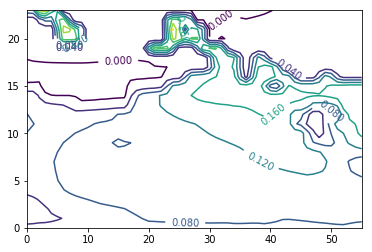

In [10]:
    print(t2m_exp.shape)
    ax = plt.contour(sflux_exp[793,:,:])
    plt.clabel(ax, inline=1, fontsize=10)
    print(sflux_exp[643,:,:])
    print(month_exp[0,:,:].shape)

In [17]:
    x_input = np.stack((sic_exp_norm[1,:,:],
                        t2m_exp_norm[1,:,:],
                        ohc_exp_norm[1,:,:],
                        month_exp[1,:,:]))
    print(x_input[1,:,:])
    print(x_input[:].shape)

[[0.26267704 0.26046318 0.25661401 ... 0.22950646 0.22708498 0.22442972]
 [0.20302922 0.20179229 0.20073181 ... 0.23818486 0.23636252 0.23451899]
 [0.19524795 0.20810658 0.22415041 ... 0.25322432 0.25219251 0.25112267]
 ...
 [0.48474634 0.48954066 0.49081374 ... 0.36213768 0.336037   0.3028926 ]
 [0.49387301 0.5059012  0.52108218 ... 0.37193518 0.34423099 0.31239209]
 [0.52729484 0.54777388 0.5776589  ... 0.38700331 0.35481465 0.32946398]]
(4, 24, 56)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [11]:
    print ('*******************  parameter for check  *********************')
    choice_exp_norm = ohc_exp_norm
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    hidden_channels = [3, 3, 2] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    #hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.005
    num_epochs = 1500
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    print ('*******************  cross validation and testing data  *********************')
    # take 10% data as cross-validation data
    cross_valid_year = 4
    # take 10% years as testing data
    test_year = 4
    # minibatch
    #iterations = 3 # training data divided into 3 sets

*******************  parameter for check  *********************
*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************


In [13]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    #print(SIC_ERAI_sum_norm[:-test_year*12])
    #print(x_input.shape)
    #print(x_input[:,:,:])
    sequence_len, _, _ = sic_exp_norm.shape
    print(sequence_len)

*******************  preview of input tensor  *********************
1824


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [13]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_oras_ohc_Barents_hl_3_kernel_3_lr_0.005_epoch_1500_validAll.pkl'))
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_sflux_Barents_hl_3_kernel_3_lr_0.005_epoch_1500_validAll.pkl'))
    print(model)
     # check the sequence length (dimension in need for post-processing)
    sequence_len, height, width = sic_exp_norm.shape

*******************  load exsited LSTM model  *********************
ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),

In [11]:
    %%time
    print ('*******************  run LSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    sequence_len, height, width = sic_exp_norm.shape

    # initialize our model
    model = deepclim.deepArray.ConvLSTM(input_channels, hidden_channels, kernel_size).cuda()
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - cross_valid_year*12*4 - test_year*12*4):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((sic_exp_norm[timestep,:,:],
                                choice_exp_norm[timestep,:,:],
                                month_exp[timestep,:,:])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).cuda()
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = np.stack((sic_exp_norm[timestep+1,:,:],
                                      choice_exp_norm[timestep+1,:,:],)) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).cuda()
            #################################################################################   
            # Forward pass
            y_pred, _ = model(x_var, timestep)
            # choose training data
            y_train = y_var        
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss = loss_fn(y_pred, y_train)
            else:
                loss += loss_fn(y_pred, y_train)
            #print (timestep)
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 10 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            #print(y_pred)
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    torch.save(model, os.path.join(output_path,'convlstm.pkl')) # save lstm model

*******************  run LSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.


G:\Anaconda\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=

In [14]:
    %%time
    #################################################################################
    ########  operational lead time dependent prediction with testing data   ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[:-test_year*12*4,:,:]
    pred_base_choice = choice_exp_norm[:-test_year*12*4,:,:]
    # predict x steps ahead
    step_lead = 6 # unit week
    # create a matrix for the prediction
    lead_pred_sic = np.zeros((test_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    lead_pred_choice = np.zeros((test_year*12*4,step_lead,height,width),dtype=float) # dim [predict time, lead time, lat, lon]
    # start the prediction loop
    for step in range(test_year*12*4):
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        # model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        for i in np.arange(1,sequence_len-test_year*12*4 + step + step_lead,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
            #############################################################################
            ###############           before time of prediction           ###############
            #############################################################################
            if i <= (sequence_len-test_year*12*4 + step):
                # create variables
                x_input = np.stack((sic_exp_norm[i-1,:,:],
                                    choice_exp_norm[i-1,:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the real prediction after the time of prediction
                if i == (sequence_len-test_year*12*4 + step):
                    lead = 0
                    # GPU data should be transferred to CPU
                    lead_pred_sic[step,0,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
                    lead_pred_choice[step,0,:,:] = last_pred[0,1,:,:].cpu().data.numpy()
            #############################################################################
            ###############            after time of prediction           ###############
            #############################################################################
            else:
                lead += 1
                # prepare predictor
                # use the predicted data to make new prediction
                x_input = np.stack((lead_pred_sic[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                    lead_pred_choice[step,i-(sequence_len-test_year*12*4 + step +1),:,:],
                                    month_exp[i-1,:,:])) #vstack,hstack,dstack
                x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                     requires_grad=False).cuda()        
                # make prediction
                last_pred, _ = model(x_var_pred, i-1)
                # record the prediction
                lead_pred_sic[step,lead,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
                lead_pred_choice[step,lead,:,:] = last_pred[0,1,:,:].cpu().data.numpy()

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 4 years of total time series are treated as test data  ************
Wall time: 34min 33s


*******************  preprocess predicted data  **********************
*******************  compute mca of training data  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


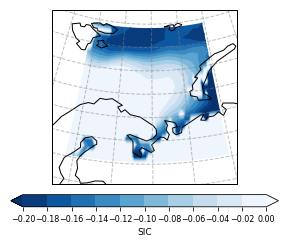

*******************  compute mca of testing data  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


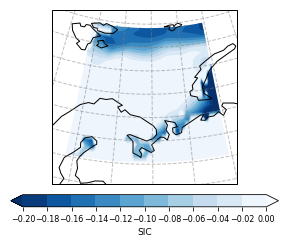

*******************  compute mca of forecast data  **********************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


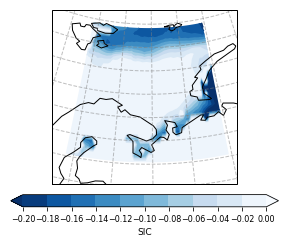

In [23]:
    #################################################################################
    ########          maximum covariance analysis of sic and ohc             ########
    #################################################################################
    print ("*******************  preprocess predicted data  **********************")
    # create index
    # correction for float point at 0
    lead_pred_sic[lead_pred_sic<0] = 0   
    # extend the dimension of sea ice mask
    sea_ice_mask_test = np.repeat(sea_ice_mask_barents[np.newaxis,:,:],test_year*48,0)
    # correct the land cells in the prediction
    for i in range(step_lead):
        lead_pred_sic[:,i,:,:] = lead_pred_sic[:,i,:,:] * sea_ice_mask_test
        lead_pred_choice[:,i,:,:] = lead_pred_choice[:,i,:,:]  * sea_ice_mask_test
    
    print ("*******************  compute mca of training data  **********************")
    # take the dimensions of input fields
    nt_sic, ny_sic, nx_sic = sic_exp_norm[:-cross_valid_year*12*4-test_year*12*4, :, :].shape
    nt_ohc, ny_ohc, nx_ohc = ohc_exp_norm[:-cross_valid_year*12*4-test_year*12*4, :, :].shape
    # reshape the matrix
    sic_exp_norm_2D = np.reshape(sic_exp_norm[:-cross_valid_year*12*4-test_year*12*4, :, :],
                                 [nt_sic, ny_sic * nx_sic], order='F')
    ohc_exp_norm_2D = np.reshape(ohc_exp_norm[:-cross_valid_year*12*4-test_year*12*4, :, :],
                                 [nt_ohc, ny_ohc * nx_ohc], order='F')
    # calculate covariance matrix -> keep the spatial dimension
    covariance_exp = np.dot(sic_exp_norm_2D.T, ohc_exp_norm_2D) / (nt_sic-1)
    # apply the SVD
    U, sigma, V = np.linalg.svd(covariance_exp, full_matrices=False,
                                compute_uv = True)
    # sklearn.decomposition.TruncatedSVD (alternative)
    sigma_diag = np.diag(sigma)
    # Take the 1st mode of left pattern and right pattern and plot
    MCA_series_sic = np.dot(sic_exp_norm_2D, U[:,0])
    MCA_left_pattern_sic = U[:,0] * np.std(MCA_series_sic)
    
    MCA_series_ohc = np.dot(ohc_exp_norm_2D, V[0,:].T)
    MCA_right_pattern_ohc = V[0,:] * np.std(MCA_series_ohc)
    
    # reshape U and V matrix
    MCA_left_pattern_sic = np.reshape(MCA_left_pattern_sic, 
                                      [ny_sic, nx_sic], order='F')
    MCA_right_pattern_ohc = np.reshape(MCA_right_pattern_ohc,
                                       [ny_ohc, nx_ohc], order='F')
    # plot
    label = 'SIC'
    ticks = [i for i in np.linspace(-0.2,0.0,11)]
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   MCA_left_pattern_sic, label, ticks,
                                   os.path.join(output_path,'spatial_sic_mca_training.png'),
                                   boundary='Barents_Polar', colormap='Blues_r')    
    print ("*******************  compute mca of testing data  **********************")
    nt_sic, ny_sic, nx_sic = sic_exp_norm[-test_year*12*4:, :, :].shape
    nt_ohc, ny_ohc, nx_ohc = ohc_exp_norm[-test_year*12*4:, :, :].shape
    # reshape the matrix
    sic_exp_norm_2D = np.reshape(sic_exp_norm[-test_year*12*4:, :, :,],
                                 [nt_sic, ny_sic * nx_sic], order='F')
    ohc_exp_norm_2D = np.reshape(ohc_exp_norm[-test_year*12*4:, :, :,],
                                 [nt_ohc, ny_ohc * nx_ohc], order='F')
    # calculate covariance matrix -> keep the spatial dimension
    covariance_exp = np.dot(sic_exp_norm_2D.T, ohc_exp_norm_2D) / (nt_sic-1)
    # apply the SVD
    U, sigma, V = np.linalg.svd(covariance_exp, full_matrices=False,
                                compute_uv = True)
    # sklearn.decomposition.TruncatedSVD (alternative)
    sigma_diag = np.diag(sigma)
    # Take the 1st mode of left pattern and right pattern and plot
    MCA_series_sic = np.dot(sic_exp_norm_2D, U[:,0])
    MCA_left_pattern_sic = U[:,0] * np.std(MCA_series_sic)
    
    MCA_series_ohc = np.dot(ohc_exp_norm_2D, V[0,:].T)
    MCA_right_pattern_ohc = V[0,:] * np.std(MCA_series_ohc)
    # reshape U and V matrix
    MCA_left_pattern_sic = np.reshape(MCA_left_pattern_sic, 
                                      [ny_sic, nx_sic], order='F')
    MCA_right_pattern_ohc = np.reshape(MCA_right_pattern_ohc,
                                       [ny_ohc, nx_ohc], order='F')    
    # plot
    label = 'SIC'
    ticks = [i for i in np.linspace(-0.2,0.0,11)]
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   MCA_left_pattern_sic, label, ticks,
                                   os.path.join(output_path,'spatial_sic_mca_testing.png'),
                                   boundary='Barents_Polar', colormap='Blues_r')        
    print ("*******************  compute mca of forecast data  **********************")
    nt_sic, ny_sic, nx_sic = lead_pred_sic[:, 0, :, :].shape
    nt_ohc, ny_ohc, nx_ohc = lead_pred_choice[:, 0, :, :].shape
    # reshape the matrix
    sic_exp_norm_2D = np.reshape(lead_pred_sic[:, 0, :, :],
                                 [nt_sic, ny_sic * nx_sic], order='F')
    ohc_exp_norm_2D = np.reshape(lead_pred_choice[:, 0, :, :],
                                 [nt_ohc, ny_ohc * nx_ohc], order='F')
    # calculate covariance matrix -> keep the spatial dimension
    covariance_exp = np.dot(sic_exp_norm_2D.T, ohc_exp_norm_2D) / (nt_sic-1)
    # apply the SVD
    U, sigma, V = np.linalg.svd(covariance_exp, full_matrices=False,
                                compute_uv = True)
    # sklearn.decomposition.TruncatedSVD (alternative)
    sigma_diag = np.diag(sigma)
    # Take the 1st mode of left pattern and right pattern and plot
    MCA_series_sic = np.dot(sic_exp_norm_2D, U[:,0])
    MCA_left_pattern_sic = U[:,0] * np.std(MCA_series_sic)
    
    MCA_series_ohc = np.dot(ohc_exp_norm_2D, V[0,:].T)
    MCA_right_pattern_ohc = V[0,:] * np.std(MCA_series_ohc)
    # reshape U and V matrix
    MCA_left_pattern_sic = np.reshape(MCA_left_pattern_sic, 
                                      [ny_sic, nx_sic], order='F')
    MCA_right_pattern_ohc = np.reshape(MCA_right_pattern_ohc,
                                       [ny_ohc, nx_ohc], order='F')    
    # plot
    label = 'SIC'
    ticks = [i for i in np.linspace(-0.2,0.0,11)]
    deepclim.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                                   MCA_left_pattern_sic, label, ticks,
                                   os.path.join(output_path,'spatial_sic_mca_forecast.png'),
                                   boundary='Barents_Polar', colormap='Blues_r')      